# NZU price dynamics 

This notebook (i) takes historical data on the price of New Zealand Units (NZUs) in the New Zealand Emissions Trading Scheme (NZ-ETS) and (ii) performs Monte Carlo analysis to make projections into the future.

## Monte Carlo
Assuming price dynamics follows [geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion), it can be simulated using a discrete-time Markov chain Monte Carlo (MCMC) by repeatedly applying the following recurrence relation, 

$$
p^{(t+1)} = p^{(t)}\exp(d+\xi), 
$$

where $t \in \{0,1,2,\dots\}$ indexes regular timesteps (which could represent days, months, or years), $d$ is a constant drift parameter, and $\xi$ is a normally distributed random variable, i.e. $\xi \sim \mathcal{N}(0,\sigma)$, with the standard deviation $\sigma$ (and variance $\sigma^{2}$) determining price volatility. Note that the underlying assumption here is that price will move in steps that are lognormally distributed, i.e.

$$
r^{(t+1)} := \ln\left(\frac{p^{(t+1)}}{p^{(t)}}\right) \sim \mathcal{N}(d,\sigma).
$$

The two parameters, $d$ and $\sigma$, can be inferred from data on past prices, i.e. a historical dataset $P_{H} = \{p^{(t)}, p^{(t-1)}, \dots, p^{(t-M)}\}$, from which $R_{H} = \{r^{(t)}, \dots, r^{(t-M+1)}\}$ can be calculated. The latter set of values will have an arithmetic mean $\bar{r}$ and variance $\sigma_{r}^{2}$, calculated
using 
$$
\bar{r} = \frac{1}{M}\sum_{i=0}^{M-1}r^{(t-i)} \quad \mathrm{and} \quad \sigma_{r}^{2} = \frac{1}{M-1} \sum_{i=0}^{M-1} (r^{(t-i)} - \bar{r})^{2},
$$

and, according to [this Investopedia article](https://www.investopedia.com/terms/m/montecarlosimulation.asp), the drift parameter can then be calculated using the formula

$$
d_{r} = \bar{r} - \frac{\sigma_{r}^{2}}{2}. 
$$

This formula seems similar to the "risk-neutral drift" in [these notes on geometric Brownian motion](http://www.columbia.edu/~ks20/FE-Notes/4700-07-Notes-GBM.pdf).

A simulated Markov chain $i$ starting from $p^{(0)}$ at $t=0$ should end up at a value
$$
p_{i}^{(N)} = p^{(0)} \exp\left(Nd + \sum_{t=1}^{N}\xi_{n}\right)
$$
at $t=N$. Repeating the simulation starting with the same initial condition will produce another Markov chain $j$ with a different endpoint, i.e. $p_{j}^{(N)} \neq p_{i}^{(N)}$. Repeating the simulation sufficiently many times should reveal that the endpoints will be lognormally distributed with the mean value of $Nd_{r}$ and standard deviation of $\sqrt{N}\sigma_{r}$, i.e.

$$
\ln\left(\frac{p^{(N)}}{p^{(0)}}\right) \sim \mathcal{N}(Nd_{r},\sqrt{N}\sigma_{r}).
$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
#source='./nzu-month-price.csv'
source='https://github.com/theecanmole/nzu/raw/master/nzu-month-price.csv'
df = pd.read_csv(source, parse_dates=[0])

In [9]:
date = list(df['month'])
price = list(df['price'])

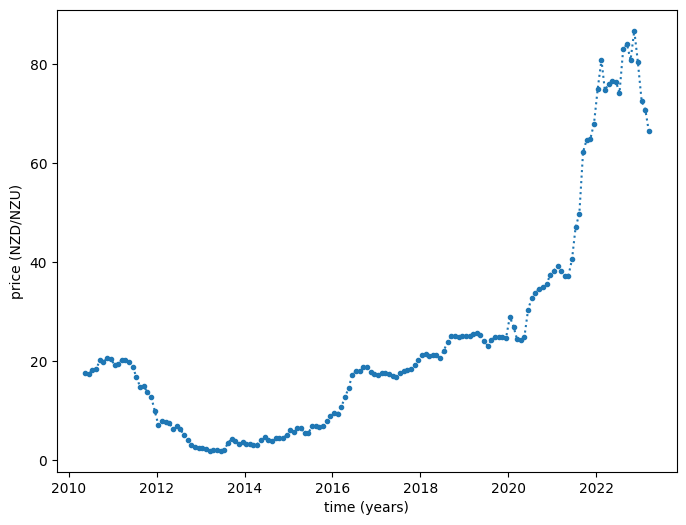

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(date, price, linestyle=':', marker='.')
ax.set_xlabel('time (years)')
ax.set_ylabel('price (NZD/NZU)')
plt.show()

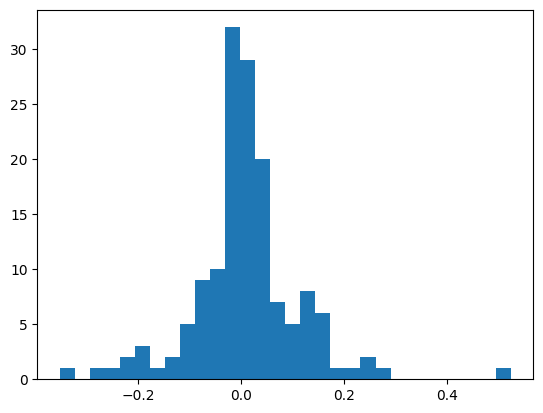

In [5]:
logreturns = [np.log(price[i]/price[i-1]) for i in range(1,len(price))]
plt.hist(logreturns, bins=30)
plt.show()

Calculate the average, variance, standard deviation, and drift.

In [6]:
ave = sum(logreturns)/len(logreturns)
var = sum([(r-ave)**2 for r in logreturns])/(len(logreturns)-1)
drift = ave - 0.5*var
sd = np.sqrt(var)

In [7]:
np.random.seed(seed=1)
projections = []
for i in range(20000):
    projection = [price[-1]]
    for j in range(60):
        rand = np.random.normal(loc=0.0, scale=sd)
        pnew = projection[-1]*np.exp(drift + rand)
        projection.append(pnew)
    projections.append(projection)

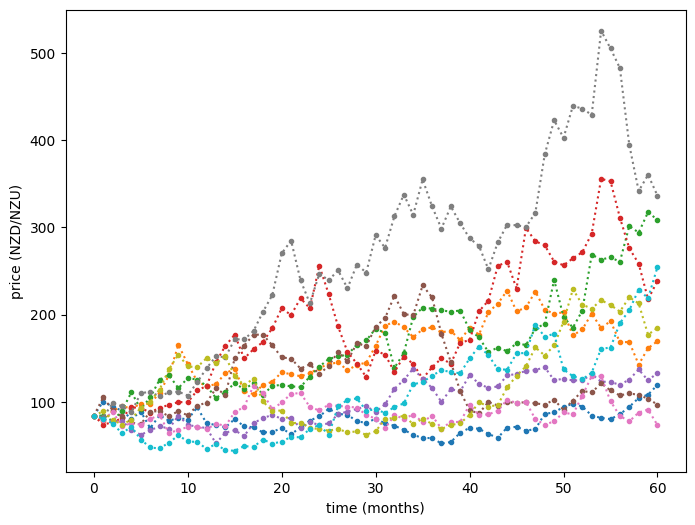

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
    ax.plot(projections[i], linestyle=':', marker='.')
ax.set_xlabel('time (months)')
ax.set_ylabel('price (NZD/NZU)')
plt.show()

In [9]:
logreturns12 = [np.log(proj[12]/proj[1]) for proj in projections]
logreturns24 = [np.log(proj[24]/proj[1]) for proj in projections]
logreturns60 = [np.log(proj[60]/proj[1]) for proj in projections]

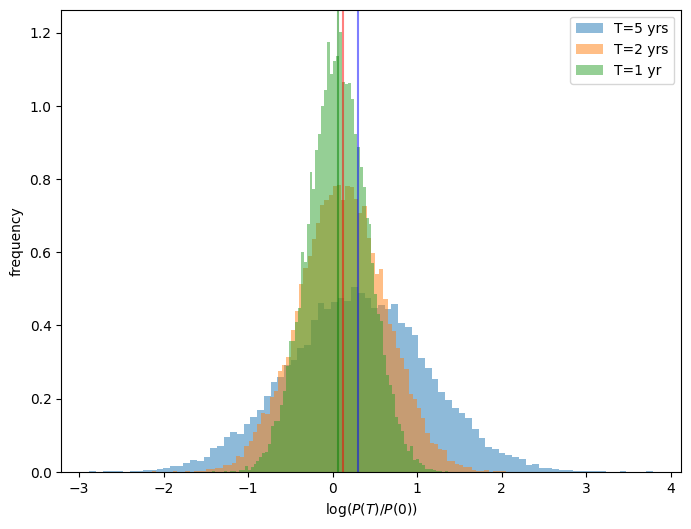

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('$\log(P(T)/P(0))$')
ax.set_ylabel('frequency')
ax.hist(logreturns60, bins='auto', alpha=0.5, density=True, label='T=5 yrs')
ax.hist(logreturns24, bins='auto', alpha=0.5, density=True, label='T=2 yrs')
ax.hist(logreturns12, bins='auto', alpha=0.5, density=True, label='T=1 yr')
ax.axvline(x=60*drift, color='b', alpha=0.5)
ax.axvline(x=24*drift, color='r', alpha=0.5)
ax.axvline(x=12*drift, color='g', alpha=0.5)
ax.legend()
plt.show()

In [1]:
from functions import gbm_forecast

## NZU price dynamics

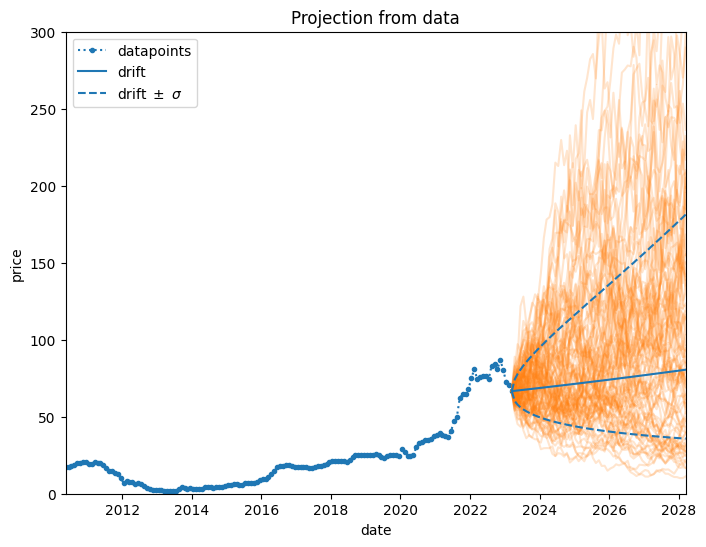

In [5]:
source='https://github.com/theecanmole/nzu/raw/master/nzu-month-price.csv'
df = pd.read_csv(source, parse_dates=[0])
df.rename(columns={'month':'date'}, inplace=True)
fig = gbm_forecast(df)

In [7]:
df.tail(5)

,date,price,decimal
150,2022-11-15,86.82,2022.875000
151,2022-12-15,80.43,2022.958333
152,2023-01-15,72.61,2023.041667
153,2023-02-15,70.81,2023.125000
154,2023-03-15,66.61,2023.208333


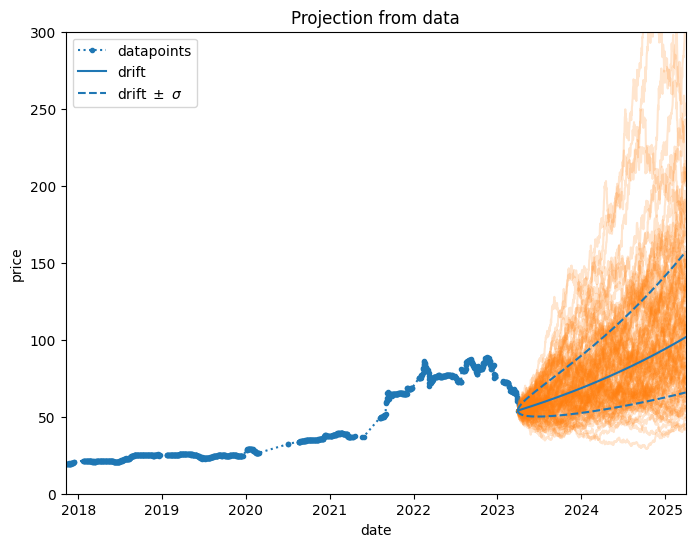

In [4]:
source='./commtrade-price.csv'
df = pd.read_csv(source, parse_dates=[0])
fig = gbm_forecast(df, tscale='days', nsteps = 731)

## NZU monthly transfers

In [14]:
source='https://www.epa.govt.nz/assets/Uploads/Documents/Emissions-Trading-Scheme/Reports/Carbon-markets/NZETR-unit-transfers.xlsx'
df_trans = pd.read_excel(source, header=1, parse_dates=[0], skipfooter=2)
df_trans.rename(columns={'Month and Year':'date'}, inplace=True)

In [16]:
df_trans

,date,AAU,CER,ERU,RMU,NZU,Total
0,2008-01-01,0,0.0,0,0,0,0
1,2008-02-01,0,0.0,0,0,0,0
2,2008-03-01,0,108.0,0,0,0,108
3,2008-04-01,0,20.0,0,0,0,20
4,2008-05-01,0,0.0,0,0,0,0
...,...,...,...,...,...,...,...
172,2022-05-01,0,0.0,0,0,20605009,20605009
173,2022-06-01,0,0.0,0,0,9829184,9829184
174,2022-07-01,0,0.0,0,0,10569019,10569019
175,2022-08-01,0,0.0,0,0,7936985,7936985


<AxesSubplot: xlabel='date'>

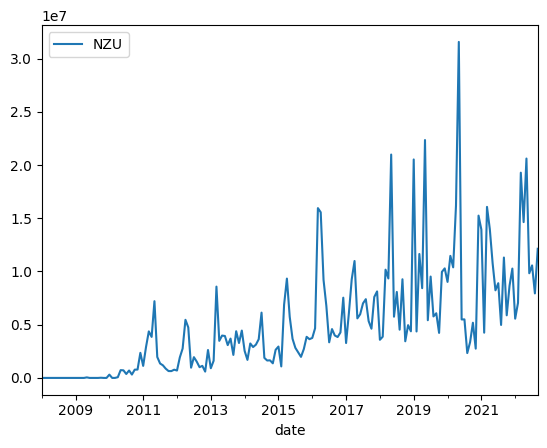

In [17]:
df_trans.plot("date","NZU")

## NZU voluntary cancellations

In [18]:
source='https://www.epa.govt.nz/assets/Uploads/Documents/Emissions-Trading-Scheme/Reports/Voluntary-unit-cancellations.xlsx'

In [40]:
df_cans = pd.read_excel(source, header=1, usecols="B,E,F", parse_dates=[0], skipfooter=3)
df_cans.rename(columns={'Cancellation Date':'date', 'Number of units per cancellation':'units', 'Unit Type':'type'}, inplace=True)
df_cans = df_cans[df_cans['units'].notna()]
df_cans.reset_index(drop=True, inplace=True)
df_cans.head(30)

,date,units,type
0,2012-10-02,5.0,NZU
1,2017-05-04,2163.0,AAU
2,2017-05-12,3331.0,AAU
3,NaT,30.0,AAU
4,2018-02-13,7011.0,AAU
5,2018-02-13,29.0,AAU
6,2018-02-13,3975.0,AAU
7,2018-02-13,6705.0,AAU
8,2018-05-23,9.0,AAU
9,2018-05-23,6982.0,AAU


In [20]:
for i in range(1,len(df_cans)):
    if pd.isnull(df_cans.iloc[i,0]):
        df_cans.iloc[i,0] = df_cans.iloc[i-1,0]

In [44]:
df_cans_NZU = df_cans.loc[df_cans['type'] == 'NZU']
df_cans_NZU.reset_index(drop=True, inplace=True)
df_cans_NZU

,date,units,type
0,2012-10-02,5.0,NZU
1,2019-04-08,1653.0,NZU
2,2021-11-05,10.0,NZU
3,2021-11-05,130.0,NZU
4,2021-11-05,27.0,NZU
...,...,...,...
117,2013-11-29,8991.0,NZU
118,2014-11-10,9052.0,NZU
119,2016-09-16,15788.0,NZU
120,2017-11-10,5871.0,NZU


<AxesSubplot: xlabel='date'>

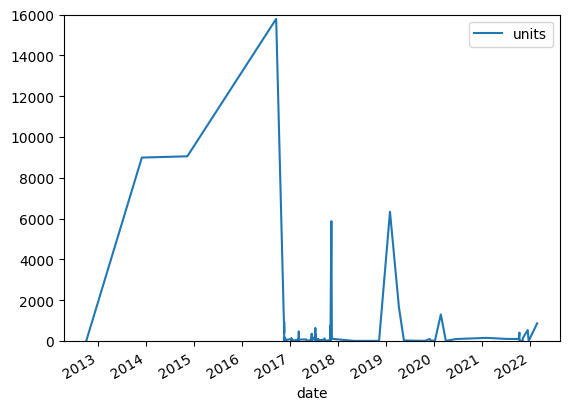

In [43]:
df_cans_NZU.plot('date', 'units', ylim=[0,16000])

Changing the above plot to a bar chart causes overcrowding of tick labels along the x-axis, which is an issue already raised on StackOverflow: https://stackoverflow.com/questions/30133280/pandas-bar-plot-changes-date-format 

<BarContainer object of 177 artists>

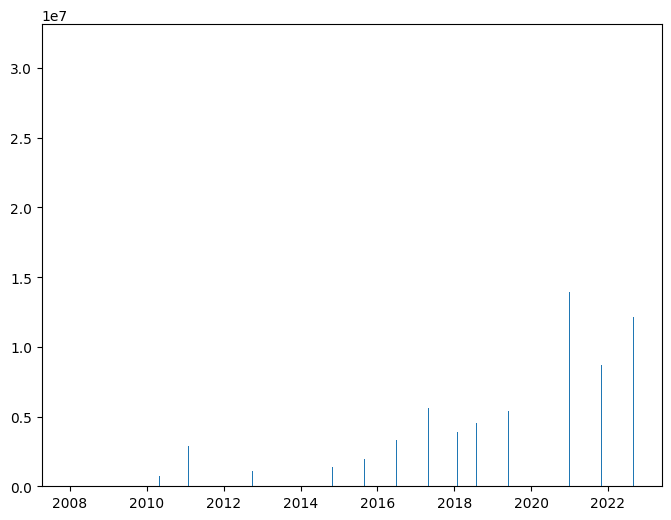

In [30]:
trans_date=list(df_trans['date'])
trans_units=list(df_trans['NZU'])
cans_date=list(df_cans_NZU['date'])
cans_units=list(df_cans['units'])

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(trans_date, trans_units)

## Brent oil price data

In [17]:
# Brent price history
source='https://www.eia.gov/dnav/pet/hist_xls/RBRTEd.xls'
df_brent = pd.read_excel(source, sheet_name=1,header=2,parse_dates=[0])
df_brent.rename(columns={'Date':'date',df_brent.columns[1]:'price'}, inplace=True)

<AxesSubplot: xlabel='date'>

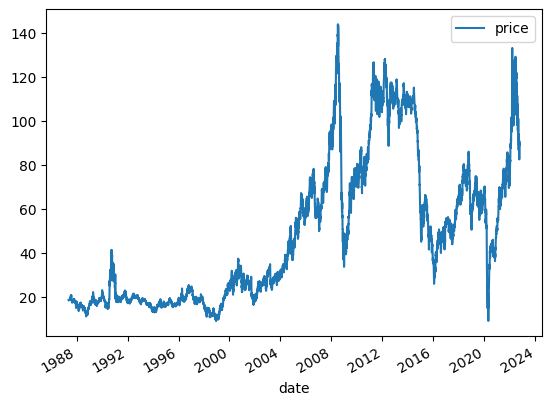

In [18]:
df_brent.plot('date','price')

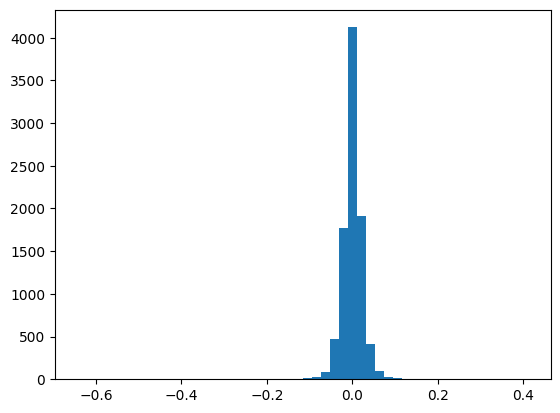

In [26]:
date = list(df_brent['date'])
price = list(df_brent['price'])
logreturns = [np.log(price[i]/price[i-1]) for i in range(1,len(price))]
plt.hist(logreturns, bins=50)
plt.show()

In [24]:
max(logreturns)

0.4120225086543235

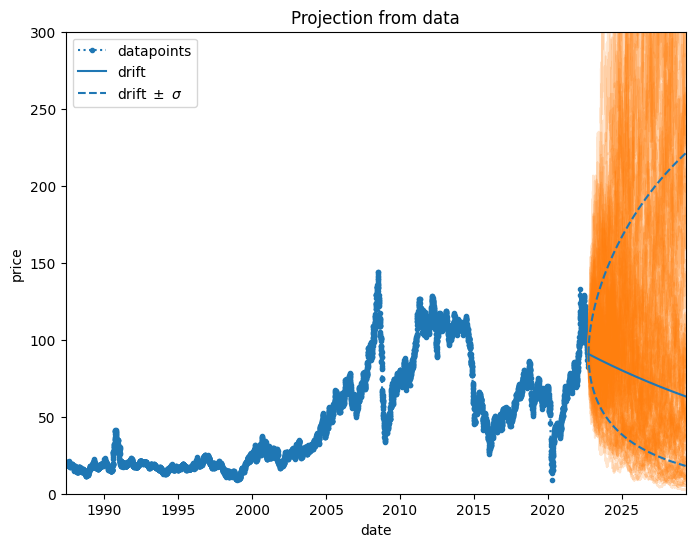

In [31]:
fig = gbm_forecast(df_brent, tscale='days', nsteps = 2400)